In [2]:
# Install required packages (if not installed)
!pip install pandas numpy seaborn matplotlib scikit-learn json5

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Display settings
pd.set_option('display.max_columns', None)

In [3]:
# Function to load JSON correctly
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)

    # Case 1: JSON with "columns" and "data" (structured format)
    if isinstance(data, dict) and "columns" in data and "data" in data:
        return pd.DataFrame(data["data"], columns=data["columns"])

    # Case 2: JSON with "schema" and "data" (like `product_info.json`)
    elif isinstance(data, dict) and "schema" in data and "data" in data:
        columns = [col["name"] for col in data["schema"]["fields"]]  # Extract column names
        return pd.DataFrame(data["data"], columns=columns)

    # Case 3: JSON is a list of dictionaries (normal JSON format)
    elif isinstance(data, list):
        return pd.DataFrame.from_records(data)

    # Case 4: JSON is a dictionary with records stored in keys
    elif isinstance(data, dict):
        return pd.DataFrame.from_dict(data, orient="index")

    else:
        raise ValueError(f"Unknown JSON structure in {file_path}")


In [4]:
# Load datasets
customers = load_json("customers_info.json")  # Customer details
transactions = load_json("customer_transaction_info.json")  # Order details
products = load_json("product_info.json")  # Product details (Fixed)
returns = load_json("orders_returned_info.json")  # Returned orders
regions = load_json("region_seller_info.json")  # Region info

# Display first few rows of each dataset
print("Customers Data:\n", customers.head(), "\n")
print("Transactions Data:\n", transactions.head(), "\n")
print("Products Data:\n", products.head(), "\n")
print("Returns Data:\n", returns.head(), "\n")
print("Regions Data:\n", regions.head(), "\n")


Customers Data:
   Customer ID    Customer Name    Segment        Country             City  \
0    CG-12520      Claire Gute   Consumer  United States        Henderson   
1    DV-13045  Darrin Van Huff  Corporate  United States      Los Angeles   
2    SO-20335   Sean O'Donnell   Consumer  United States  Fort Lauderdale   
3    BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
4    AA-10480     Andrew Allen   Consumer  United States          Concord   

            State  Postal Code Region  
0        Kentucky        42420  South  
1      California        90036   West  
2         Florida        33311  South  
3      California        90032   West  
4  North Carolina        28027  South   

Transactions Data:
          Order ID     Order Date      Ship Date       Ship Mode Customer ID  \
0  CA-2016-152156  1478563200000  1478822400000    Second Class    CG-12520   
1  CA-2016-152156  1478563200000  1478822400000    Second Class    CG-12520   
2  CA-2016-138688  14

In [5]:
# Standardize Gender Values
def clean_gender(gender):
    if pd.isna(gender) or gender in ['None', 'G']:
        return 'Unknown'
    elif gender.lower() in ['f', 'femail', 'female']:
        return 'Female'
    elif gender.lower() in ['m', 'male']:
        return 'Male'
    else:
        return 'Unknown'

regions[2] = regions[2].apply(clean_gender)

# Check cleaned values
print(regions[2].value_counts())


2
Female     2
Unknown    2
Name: count, dtype: int64


In [6]:
# Convert timestamps to datetime
transactions['Order Date'] = pd.to_datetime(transactions['Order Date'], unit='ms')
transactions['Ship Date'] = pd.to_datetime(transactions['Ship Date'], unit='ms')

# Check the data types
print(transactions.dtypes)


Order ID               object
Order Date     datetime64[ns]
Ship Date      datetime64[ns]
Ship Mode              object
Customer ID            object
Product ID             object
Sales                 float64
Quantity                int64
Discount              float64
Profit                float64
dtype: object


In [7]:
# Check and drop duplicates in all datasets
print(customers.duplicated().sum())
customers.drop_duplicates(inplace=True)

print(products.duplicated().sum())
products.drop_duplicates(inplace=True)

print(transactions.duplicated().sum())
transactions.drop_duplicates(inplace=True)

print(returns.duplicated().sum())
returns.drop_duplicates(inplace=True)

print(regions.duplicated().sum())
regions.drop_duplicates(inplace=True)

0
0
1
0
0


It capitalizes the first letter of each word in the Region and Segment columns.
This ensures consistency in text formatting.
Example:
Before: "north america", "enterprise customers"
After: "North America", "Enterprise Customers"

In [8]:
# Convert to consistent categorical types
customers['Region'] = customers['Region'].str.title()
customers['Segment'] = customers['Segment'].str.title()


In [9]:
# Fix encoding issues in Product Names more robustly
products['Product Name'] = products['Product Name'].apply(
    lambda x: x.encode('utf-8', errors='ignore').decode('utf-8') if isinstance(x, str) else x
)

# Display the first few rows to check if issues are resolved
print(products['Product Name'].head())


0                    Bush Somerset Collection Bookcase
1    Hon Deluxe Fabric Upholstered Stacking Chairs,...
2    Self-Adhesive Address Labels for Typewriters b...
3        Bretford CR4500 Series Slim Rectangular Table
4                       Eldon Fold 'N Roll Cart System
Name: Product Name, dtype: object


In [10]:
# Manually assign column names
regions.columns = ["Name", "Region", "Gender", "AgeOrID"]


In [11]:
import pandas as pd

# Merge customer transactions with customer details
merged_df = transactions.merge(customers, on="Customer ID", how="left")

# Merge with product details
merged_df = merged_df.merge(products, on="Product ID", how="left")

# Merge with returned orders
merged_df = merged_df.merge(returns, on="Order ID", how="left")

# Merge with regional information
merged_df = merged_df.merge(regions, on="Region", how="left")

# Display the first few rows to check the merged dataset
merged_df.head(50)


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit,Customer Name,Segment,Country,City,State,Postal Code,Region,index,Category,Sub-Category,Product Name,Returned,Name,Gender,AgeOrID
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,0,Furniture,Bookcases,Bush Somerset Collection Bookcase,NaN,Cassandra Brandow,Female,9849
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136,Claire Gute,Consumer,United States,Houston,Texas,77070,Central,0,Furniture,Bookcases,Bush Somerset Collection Bookcase,NaN,Kelly Williams,Unknown,35
2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-BO-10001798,261.9600,2,0.00,41.9136,Claire Gute,Consumer,United States,Dallas,Texas,75217,Central,0,Furniture,Bookcases,Bush Somerset Collection Bookcase,NaN,Kelly Williams,Unknown,35
3,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,1,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",NaN,Cassandra Brandow,Female,9849
4,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820,Claire Gute,Consumer,United States,Houston,Texas,77070,Central,1,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",NaN,Kelly Williams,Unknown,35
5,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,FUR-CH-10000454,731.9400,3,0.00,219.5820,Claire Gute,Consumer,United States,Dallas,Texas,75217,Central,1,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",NaN,Kelly Williams,Unknown,35
6,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,2,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,NaN,Anna Andreadi,Female,45
7,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,Darrin Van Huff,Corporate,United States,Philadelphia,Pennsylvania,19143,East,2,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,NaN,Chuck Magee,Unknown,43
8,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,Darrin Van Huff,Corporate,United States,San Diego,California,92037,West,2,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,NaN,Anna Andreadi,Female,45
9,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,OFF-LA-10000240,14.6200,2,0.00,6.8714,Darrin Van Huff,Corporate,United States,Memphis,Tennessee,38109,South,2,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,NaN,Cassandra Brandow,Female,9849


Print the Columns names of Merged Columns
Download the the merged Dataset for the chatbot  

In [12]:
print(merged_df.columns)
from google.colab import files
import pandas as pd

# Save DataFrame as JSON
merged_df.to_json("merged_data.json", orient="records", indent=4)

# Download the file
files.download("merged_data.json")



Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'index', 'Category', 'Sub-Category', 'Product Name',
       'Returned', 'Name', 'Gender', 'AgeOrID'],
      dtype='object')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Label Encoding (Each Region → A Unique Integer)
 Label Encoding was used (i.e., each region got a unique number)

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
encoder = LabelEncoder()

# Fit on the original region data
encoder.fit(merged_df["Region"])  # Replace with the actual column name

# Get mapping
region_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
reverse_mapping = {v: k for k, v in region_mapping.items()}  # Reverse mapping

print("Region to Integer Mapping:", region_mapping)
print("Integer to Region Mapping:", reverse_mapping)


Region to Integer Mapping: {'Central': 0, 'East': 1, 'South': 2, 'West': 3}
Integer to Region Mapping: {0: 'Central', 1: 'East', 2: 'South', 3: 'West'}


In [14]:
# Create a binary target variable for printer-related purchases
merged_df['printer_purchase'] = merged_df.apply(
    lambda row: 1 if (any(keyword in str(row['Product Name']).lower() for keyword in ['printer', 'paper', 'ink']) and
                      row['Sub-Category'] in ['Machines', 'Paper', 'Supplies']) else 0,
    axis=1
)

# Display distribution of the target variable
merged_df['printer_purchase'].value_counts()

,count
printer_purchase,
0,72264
1,2106


### **Now Visualing the Data to understand Data more effectively **

<ipython-input-15-ea77fe6043f8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=merged_df['repeat_buyer'], palette="viridis")


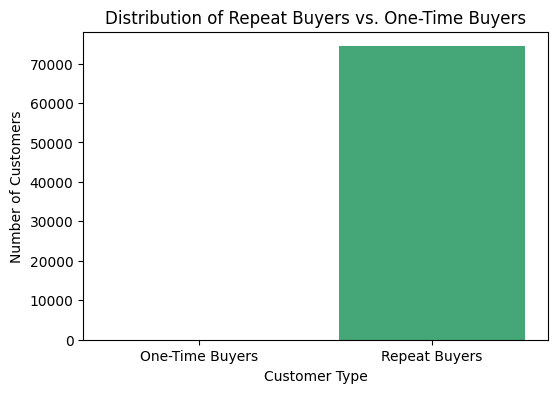

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of purchases per customer
customer_purchase_counts = merged_df.groupby('Customer ID')['Order ID'].nunique()

# Classify customers as One-Time Buyers or Repeat Buyers
merged_df['repeat_buyer'] = merged_df['Customer ID'].apply(lambda x: 1 if customer_purchase_counts[x] > 1 else 0)

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=merged_df['repeat_buyer'], palette="viridis")
plt.xticks([0, 1], ['One-Time Buyers', 'Repeat Buyers'])
plt.xlabel("Customer Type")
plt.ylabel("Number of Customers")
plt.title("Distribution of Repeat Buyers vs. One-Time Buyers")
plt.show()


<ipython-input-168-056e48ab66f6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Returned", y="Category", data=category_returns.head(10), palette="Reds_r")


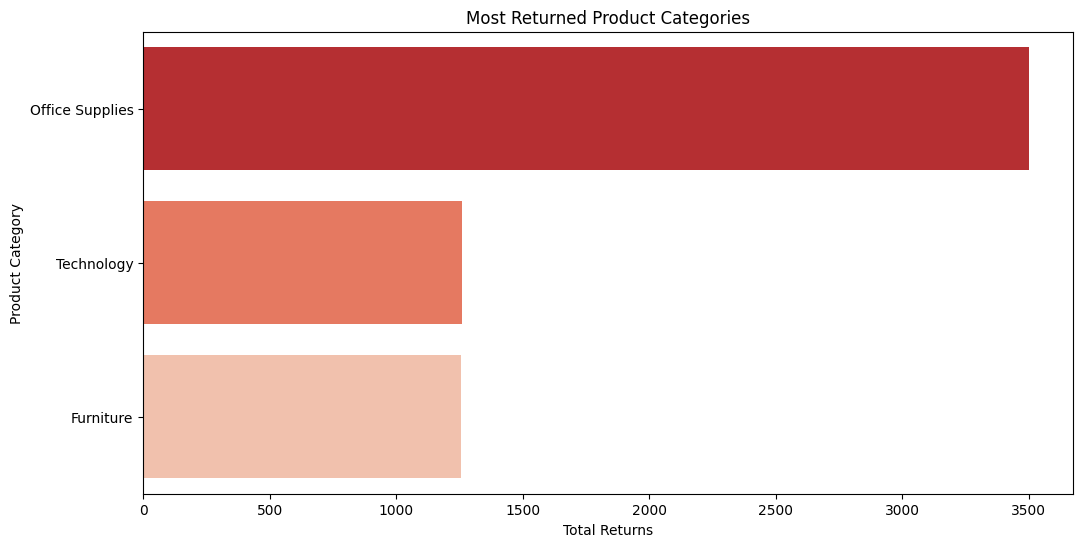

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Group by category and sum up the number of returns
category_returns = merged_df.groupby("Category")["Returned"].sum().reset_index()

# Sort by most returned categories
category_returns = category_returns.sort_values(by="Returned", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Returned", y="Category", data=category_returns.head(10), palette="Reds_r")

plt.xlabel("Total Returns")
plt.ylabel("Product Category")
plt.title("Most Returned Product Categories")
plt.show()



  Sub-Category  Returned
2      Binders      1029
6        Paper       912
7      Storage       416
1          Art       352
0   Appliances       298


<ipython-input-173-6ca7ca5ab51a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Returned", y="Sub-Category", data=returned_subcategories.head(10), palette="Blues_r")


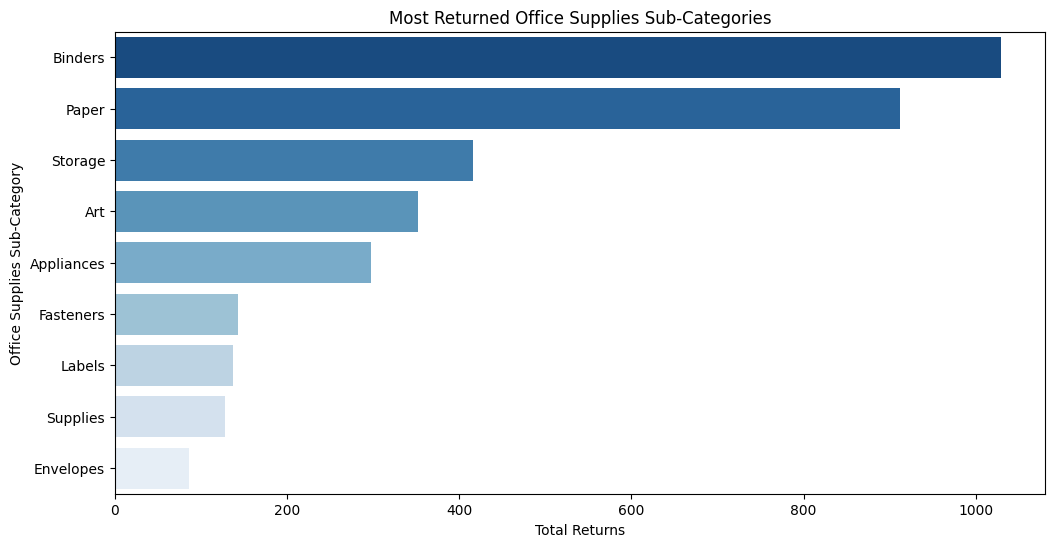

In [ ]:
office_supplies = merged_df[merged_df["Category"] == "Office Supplies"]
# Group by Sub-Category and sum the returns
returned_subcategories = office_supplies.groupby("Sub-Category")["Returned"].sum().reset_index()

# Sort by most returned sub-categories
returned_subcategories = returned_subcategories.sort_values(by="Returned", ascending=False)

print(returned_subcategories.head())  # Check top returned sub-categories
plt.figure(figsize=(12, 6))
sns.barplot(x="Returned", y="Sub-Category", data=returned_subcategories.head(10), palette="Blues_r")

plt.xlabel("Total Returns")
plt.ylabel("Office Supplies Sub-Category")
plt.title("Most Returned Office Supplies Sub-Categories")
plt.show()


    Region  Quantity
3     West      2296
1     East      2096
0  Central      1650
2    South      1058


<ipython-input-178-3aa270e5643f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y="Quantity", data=printer_sales_by_region, palette="viridis")


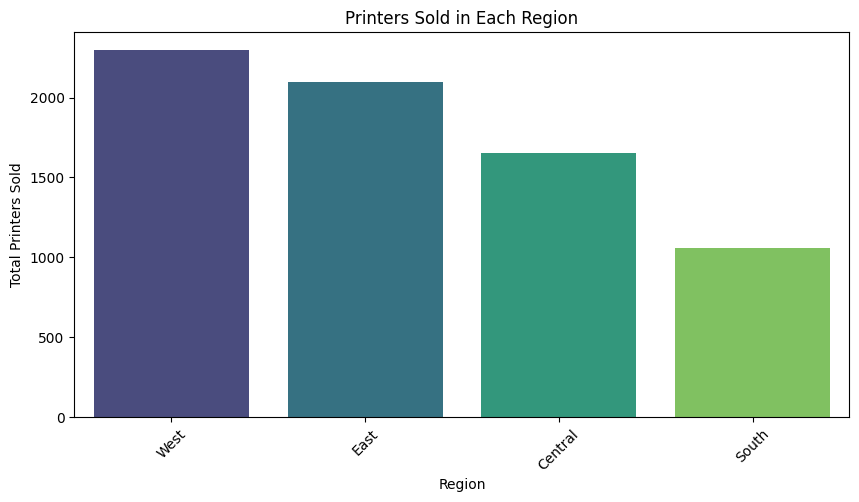

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter dataset for only "Printers" in the Category or Sub-Category
printers_sold = merged_df[merged_df["Product Name"].str.contains("Printer", case=False, na=False)]

# Group by Region and sum up the Quantity sold
printer_sales_by_region = printers_sold.groupby("Region")["Quantity"].sum().reset_index()

# Sort by highest sales
printer_sales_by_region = printer_sales_by_region.sort_values(by="Quantity", ascending=False)

print(printer_sales_by_region)  # Check values

plt.figure(figsize=(10, 5))
sns.barplot(x="Region", y="Quantity", data=printer_sales_by_region, palette="viridis")

plt.xlabel("Region")
plt.ylabel("Total Printers Sold")
plt.title("Printers Sold in Each Region")
plt.xticks(rotation=45)  # Rotate labels if needed

plt.show()

<ipython-input-27-f48a9979d188>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=purchase_distribution.index, y=purchase_distribution.values, palette="coolwarm")


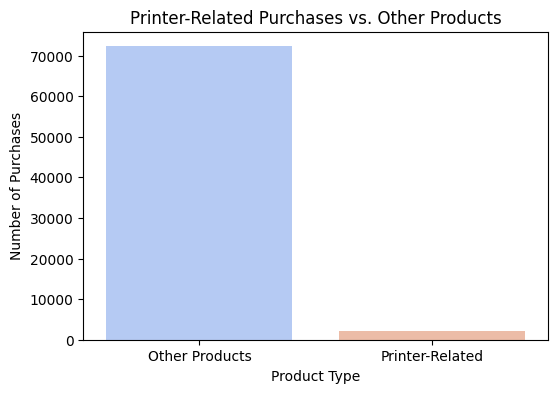

In [ ]:
# Count printer-related vs. non-printer purchases
purchase_distribution = merged_df['printer_purchase'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=purchase_distribution.index, y=purchase_distribution.values, palette="coolwarm")
plt.xticks([0, 1], ['Other Products', 'Printer-Related'])
plt.xlabel("Product Type")
plt.ylabel("Number of Purchases")
plt.title("Printer-Related Purchases vs. Other Products")
plt.show()

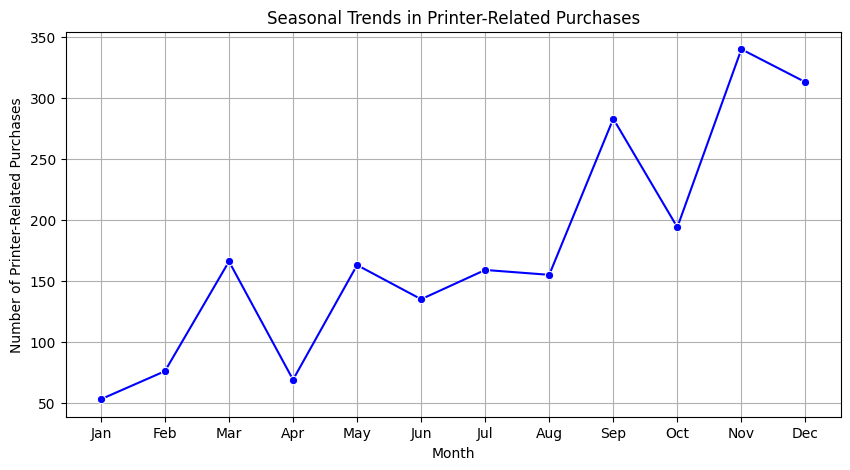

In [ ]:
# Convert order date to datetime format
merged_df['Order Date'] = pd.to_datetime(merged_df['Order Date'])

# Extract month from Order Date
merged_df['Month'] = merged_df['Order Date'].dt.month

# Aggregate printer-related sales by month
monthly_sales = merged_df.groupby('Month')['printer_purchase'].sum()

# Plot the trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker="o", color='b')
plt.xlabel("Month")
plt.ylabel("Number of Printer-Related Purchases")
plt.title("Seasonal Trends in Printer-Related Purchases")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


Text(0.5, 1.0, 'Distribution of Categories')

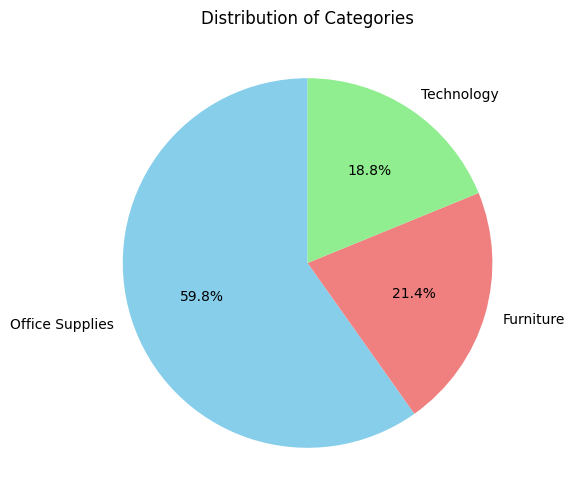

In [ ]:
category_counts = merged_df['Category'].value_counts()

# 2. Create the Pie Chart:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors = ['skyblue', 'lightcoral', 'lightgreen']) # Added colors
plt.title('Distribution of Categories')

In [ ]:
print(merged_df.columns)


Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'index', 'Category', 'Sub-Category', 'Product Name',
       'Returned', 'Name', 'Gender', 'AgeOrID', 'printer_purchase',
       'repeat_buyer', 'Month'],
      dtype='object')


In [20]:
# Create new features for customer purchase behavior analysis

# 1️⃣ Total Orders Per Customer
# Counts the number of unique orders each customer has placed
merged_df['total_orders'] = merged_df.groupby('Customer ID')['Order ID'].transform('nunique')

# 2️⃣ Total Amount Spent Per Customer
# Sums the 'Sales' column to get the total spending of each customer
merged_df['total_spent'] = merged_df.groupby('Customer ID')['Sales'].transform('sum')

# Convert 'Returned' column from 'Yes'/'No' to 1/0
merged_df['Returned'] = merged_df['Returned'].replace({'Yes': 1, 'No': 0}).fillna(0).astype(int)


# 3️⃣ Return Rate Per Customer
# Ensure 'Returned' column exists and is properly formatted (0 = Not Returned, 1 = Returned)
merged_df['Returned'] = merged_df['Returned'].fillna(0).astype(int)  # Convert NaN to 0 and ensure integer type

# Calculate return rate: (Number of returned orders) / (Total orders per customer)
merged_df['return_rate'] = merged_df.groupby('Customer ID')['Returned'].transform('mean')

# 4️⃣ Product Diversity (Unique Product Categories Bought)
# Counts the number of different 'Sub-Category' products each customer has purchased
merged_df['product_diversity'] = merged_df.groupby('Customer ID')['Sub-Category'].transform('nunique')

# ✅ Display the first few rows to check if the new features are created correctly
print(merged_df[['Customer ID', 'total_orders', 'total_spent', 'return_rate', 'product_diversity']].head())


  Customer ID  total_orders  total_spent  return_rate  product_diversity
0    CG-12520             3      3446.34          0.0                  5
1    CG-12520             3      3446.34          0.0                  5
2    CG-12520             3      3446.34          0.0                  5
3    CG-12520             3      3446.34          0.0                  5
4    CG-12520             3      3446.34          0.0                  5


<ipython-input-20-5971b2e79a26>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['Returned'] = merged_df['Returned'].replace({'Yes': 1, 'No': 0}).fillna(0).astype(int)


    Region  total_orders
0  Central        145354
1     East        170550
2    South         99340
3     West        196775


<ipython-input-21-d444b88e2ae3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Region", y='total_orders', data=region_sales, palette="viridis")


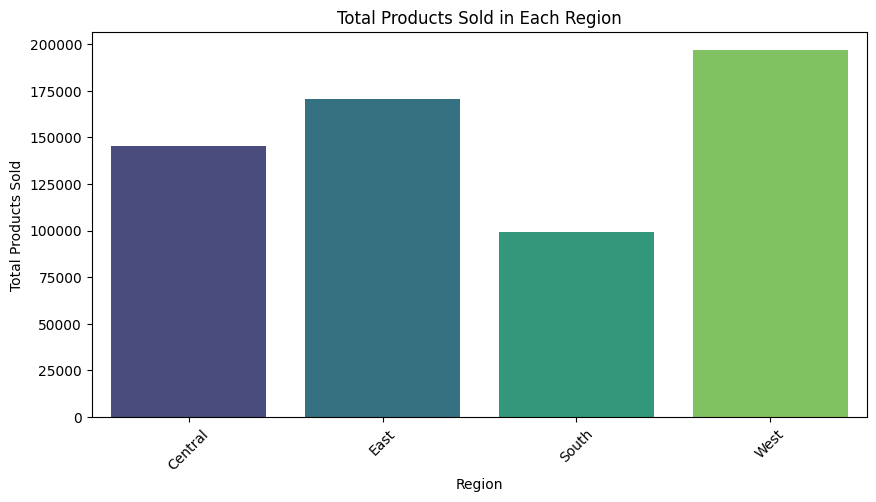

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate total products sold by region
region_sales = merged_df.groupby("Region")['total_orders'].sum().reset_index()

print(region_sales)
plt.figure(figsize=(10, 5))
sns.barplot(x="Region", y='total_orders', data=region_sales, palette="viridis")

plt.xlabel("Region")
plt.ylabel("Total Products Sold")
plt.title("Total Products Sold in Each Region")
plt.xticks(rotation=45)  # Rotate labels if needed

plt.show()
 # Check values

    Region      Segment  Count
0  Central     Consumer   8962
1  Central    Corporate   5350
2  Central  Home Office   3315
3     East     Consumer  10550
4     East    Corporate   6502


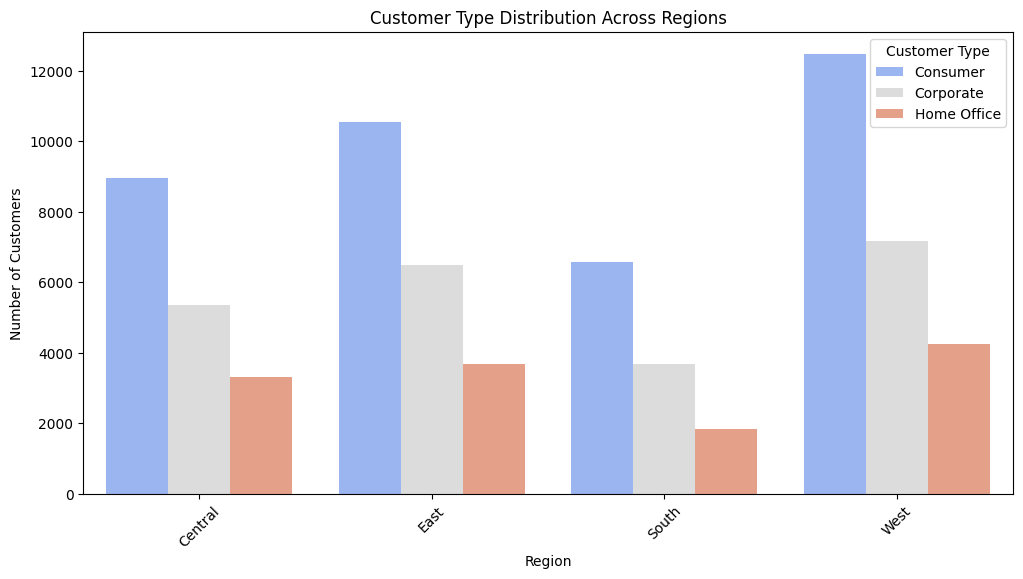

In [40]:
# Group by Region and Segment (Customer Type)
customer_type_distribution = merged_df.groupby(["Region", "Segment"]).size().reset_index(name="Count")

print(customer_type_distribution.head())  # Check the data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="Region", y="Count", hue="Segment", data=customer_type_distribution, palette="coolwarm")

plt.xlabel("Region")
plt.ylabel("Number of Customers")
plt.title("Customer Type Distribution Across Regions")
plt.legend(title="Customer Type")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


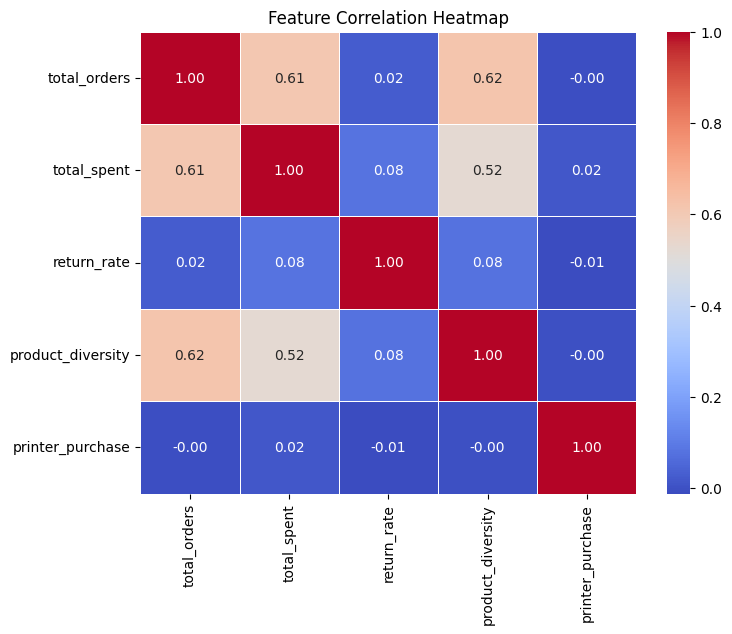

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features for correlation analysis
correlation_data = merged_df[['total_orders', 'total_spent', 'return_rate', 'product_diversity', 'printer_purchase']]

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [22]:
import pandas as pd
import numpy as np

# Ensure 'Order Date' is in datetime format
merged_df['Order Date'] = pd.to_datetime(merged_df['Order Date'])

# Get the latest date in the dataset for calculating recent purchases
latest_date = merged_df['Order Date'].max()

# 1️⃣ Total Orders Per Customer
merged_df['total_orders'] = merged_df.groupby('Customer ID')['Order ID'].transform('nunique')

# 2️⃣ Total Amount Spent Per Customer
merged_df['total_spent'] = merged_df.groupby('Customer ID')['Sales'].transform('sum')

# 3️⃣ Printer-Related Purchases in the Last 6 Months
six_months_ago = latest_date - pd.DateOffset(months=6)
merged_df['printer_purchases_last_6m'] = merged_df.apply(
    lambda row: 1 if (row['Order Date'] >= six_months_ago and row['printer_purchase'] == 1) else 0, axis=1
)
merged_df['printer_purchases_last_6m'] = merged_df.groupby('Customer ID')['printer_purchases_last_6m'].transform('sum')



# 5️⃣ Average Order Value (AOV)
merged_df['average_order_value'] = merged_df['total_spent'] / merged_df['total_orders']
merged_df['average_order_value'].fillna(0, inplace=True)  # Handle division by zero

# 6️⃣ Product Diversity (Unique Product Categories Purchased)
merged_df['product_diversity'] = merged_df.groupby('Customer ID')['Sub-Category'].transform('nunique')

# 7️⃣ Encode Region (Convert Categorical to Numeric)
merged_df['region'] = merged_df['Region'].astype('category').cat.codes

# 8️⃣ High-Value Customer (Binary Label)
high_value_threshold = merged_df['total_spent'].quantile(0.75)  # Top 25% spenders
merged_df['high_value_customer'] = merged_df['total_spent'].apply(lambda x: 1 if x >= high_value_threshold else 0)




<ipython-input-22-9fab84a5f6cc>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['average_order_value'].fillna(0, inplace=True)  # Handle division by zero


In [ ]:
merged_df.shape

(74370, 36)

### 🔹 Step 1: Prepare Data for Training
1️⃣ Define Features (X) and Target (y)

In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Select relevant features for training
feature_columns = ['total_orders', 'total_spent', 'printer_purchases_last_6m',
                   'return_rate', 'average_order_value', 'product_diversity',
                   'region', 'high_value_customer']

X = merged_df[feature_columns]  # Features
y = merged_df['printer_purchase']  # Target variable

# Handle class imbalance using SMOTE (Only if imbalance exists)
if y.value_counts()[0] / y.value_counts()[1] > 2:  # Check if imbalance is significant
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X, y = smote.fit_resample(X, y)

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features for Logistic Regression & Neural Networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression Model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred_log_reg = log_reg.predict(X_test_scaled)
print("🔹 Logistic Regression Results:")
print(classification_report(y_test, y_pred_log_reg))


🔹 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.59      0.72      0.65     14453
           1       0.64      0.50      0.56     14453

    accuracy                           0.61     28906
   macro avg       0.62      0.61      0.61     28906
weighted avg       0.62      0.61      0.61     28906



In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate Model
y_pred_rf = rf_clf.predict(X_test)
print("🔹 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74     14453
           1       0.74      0.70      0.72     14453

    accuracy                           0.73     28906
   macro avg       0.73      0.73      0.73     28906
weighted avg       0.73      0.73      0.73     28906



In [28]:
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict Class Labels
y_pred_xgb = xgb_clf.predict(X_test)

# 🔹 Predict Probability Scores
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]  # Extract probability of class '1' (purchase)

# Evaluate XGBoost Model




In [31]:
import tensorflow as tf
from tensorflow import keras

# Define Neural Network Architecture
nn_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary Classification
])

# Compile Model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate Model
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")
print("🔹 Neural Network Results:")
print(classification_report(y_test, y_pred_nn))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3614/3614 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6202 - loss: 0.6459 - val_accuracy: 0.6447 - val_loss: 0.6194
Epoch 2/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6588 - loss: 0.6123 - val_accuracy: 0.6662 - val_loss: 0.6009
Epoch 3/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6744 - loss: 0.5929 - val_accuracy: 0.6721 - val_loss: 0.5888
Epoch 4/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6875 - loss: 0.5791 - val_accuracy: 0.6896 - val_loss: 0.5776
Epoch 5/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6961 - loss: 0.5699 - val_accuracy: 0.7069 - val_loss: 0.5641
Epoch 6/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7050 - loss: 0.5611 - val_accuracy: 0.7067 - val_loss: 0.5616
Epoch 7/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7069 - loss: 0.5578 - val_accuracy: 0.7010 - val_loss: 0.5544
Epoch 8/20
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7103 - loss: 0.5505 - val_accu

# Hyperparameter Tuning with GridSearchCV
### For Random Forest & XGBoost, we can tune hyperparameters using GridSearchCV.

In [29]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train, y_train)

print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Random Forest Parameters: {'max_depth': 15, 'n_estimators': 200}


🔹 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.59      0.72      0.65     14453
           1       0.64      0.50      0.56     14453

    accuracy                           0.61     28906
   macro avg       0.62      0.61      0.61     28906
weighted avg       0.62      0.61      0.61     28906

--------------------------------------------------
🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74     14453
           1       0.74      0.70      0.72     14453

    accuracy                           0.73     28906
   macro avg       0.73      0.73      0.73     28906
weighted avg       0.73      0.73      0.73     28906

--------------------------------------------------
🔹 XGBoost Results:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     14453
           1       0.75      0.84      0.79     14453

    a

<Figure size 1500x600 with 0 Axes>

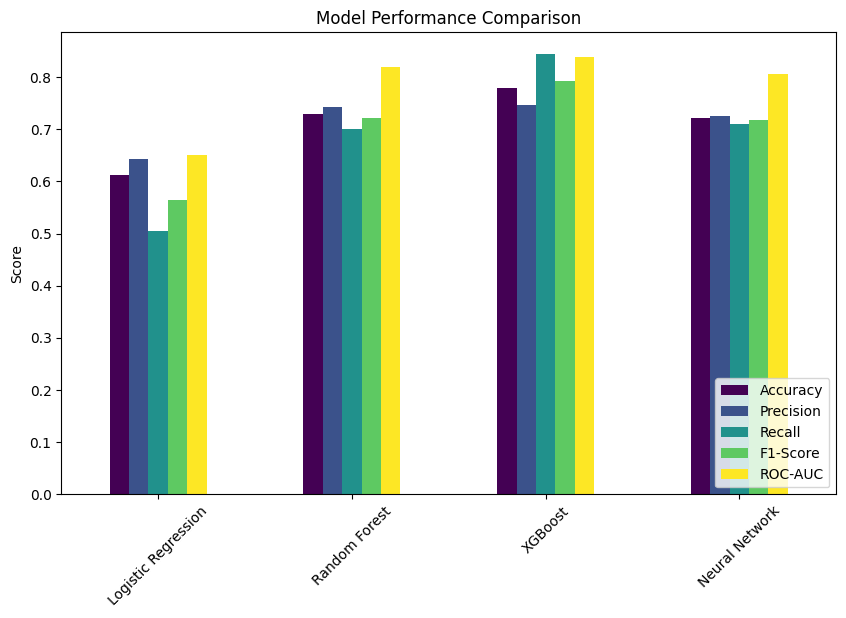

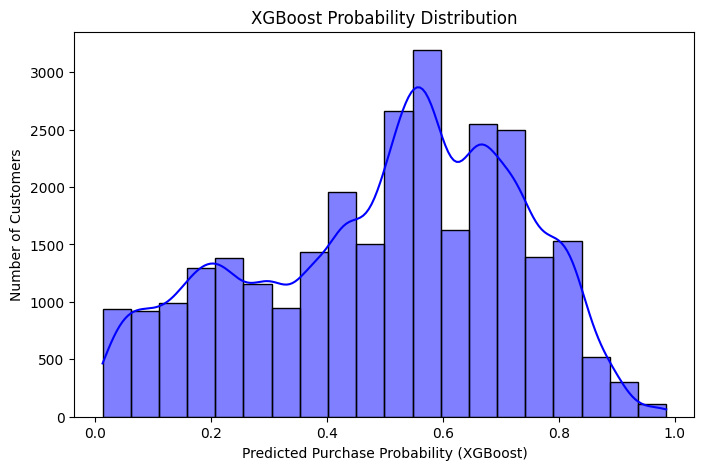

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 📌 Create a dictionary to store model results
model_results = {}

# 📌 Function to evaluate a model and store metrics
def evaluate_model(model_name, y_true, y_pred, y_prob=None):
    model_results[model_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob) if y_prob is not None else "N/A"
    }
    print(f"🔹 {model_name} Results:")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# 📌 Evaluate Logistic Regression
evaluate_model("Logistic Regression", y_test, y_pred_log_reg, y_prob=log_reg.predict_proba(X_test_scaled)[:, 1])

# 📌 Evaluate Random Forest
evaluate_model("Random Forest", y_test, y_pred_rf, y_prob=rf_clf.predict_proba(X_test)[:, 1])

# 📌 Evaluate XGBoost
evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob=y_prob_xgb)  # y_prob_xgb already stores probability

# 📌 Evaluate Neural Network
evaluate_model("Neural Network", y_test, y_pred_nn, y_prob=nn_model.predict(X_test_scaled).flatten())

# 📌 Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(model_results).T  # Transpose for readability

# 📌 Print Model Comparison Table
print("\n📊 Model Performance Comparison:\n")
print(results_df)

# 📌 Plot Performance Metrics
plt.figure(figsize=(15, 6))
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()




# 📌 Probability Distribution Analysis for XGBoost
plt.figure(figsize=(8, 5))
sns.histplot(y_prob_xgb, bins=20, kde=True, color="blue")
plt.xlabel("Predicted Purchase Probability (XGBoost)")
plt.ylabel("Number of Customers")
plt.title("XGBoost Probability Distribution")
plt.show()



In [33]:
import pickle
import shutil

# Save the XGBoost model as a .pkl file
model_filename = "xgboost_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_clf, file)

# Move the file to a download-friendly location
shutil.move(model_filename, f"/content/{model_filename}")



'/content/xgboost_model.pkl'

In [ ]:
# Function to take user input for customer features
def get_user_input():
    print("\n📌 Enter Customer Details:")

    total_orders = int(input("Total Orders Placed: "))
    total_spent = float(input("Total Amount Spent: "))
    printer_purchases_last_6m = int(input("Printer Purchases in Last 6 Months: "))
    return_rate = float(input("Return Rate (0 to 1): "))
    average_order_value = float(input("Average Order Value: "))
    product_diversity = int(input("Unique Product Categories Purchased: "))
    region = int(input("Customer Region Code (0,1,2,...): "))  # Assuming encoded categorical values
    high_value_customer = int(input("Is the Customer a High Spender? (1 = Yes, 0 = No): "))

    # Create DataFrame with the user input
    user_df = pd.DataFrame([[total_orders, total_spent, printer_purchases_last_6m, return_rate,
                             average_order_value, product_diversity, region, high_value_customer]],
                           columns=['total_orders', 'total_spent', 'printer_purchases_last_6m',
                                    'return_rate', 'average_order_value', 'product_diversity',
                                    'region', 'high_value_customer'])

    return user_df

# Take user input
user_data = get_user_input()

# Standardize input if required (only for models that need scaling like Logistic Regression & Neural Networks)
user_data_scaled = scaler.transform(user_data)  # Ensure you trained a `scaler` earlier

# Predict using XGBoost (Best Model)
predicted_prob = xgb_clf.predict_proba(user_data)[0, 1]  # Extract probability of class 1

# Predict class based on threshold
threshold = 0.6  # Adjust based on business needs
predicted_class = int(predicted_prob > threshold)

# Display Results
print("\n🔹 **Prediction Result** 🔹")
print(f"📌 Probability of Customer Purchasing a Printer-Related Product: {predicted_prob:.2f}")
print(f"📌 Predicted Class (1 = Will Buy, 0 = Won't Buy): {predicted_class}")

# Give Business Insight
if predicted_prob > 0.8:
    print("\n🚀 **High Potential Buyer!** Recommend discounts or special offers.")
elif predicted_prob > 0.5:
    print("\n🛒 **Moderate Chance of Buying.** Consider targeted marketing.")
else:
    print("\n📉 **Low Chance of Buying.** Recommend follow-up engagement strategies.")



📌 Enter Customer Details:
Total Orders Placed: 5
Total Amount Spent: 5000
Printer Purchases in Last 6 Months: 0
Return Rate (0 to 1): 0.99
Average Order Value: 200
Unique Product Categories Purchased: 1
Customer Region Code (0,1,2,...): 0
Is the Customer a High Spender? (1 = Yes, 0 = No): 0

🔹 **Prediction Result** 🔹
📌 Probability of Customer Purchasing a Printer-Related Product: 0.13
📌 Predicted Class (1 = Will Buy, 0 = Won't Buy): 0

📉 **Low Chance of Buying.** Recommend follow-up engagement strategies.


In [ ]:
print(merged_df['Region'].unique())

['South' 'Central' 'West' 'East']


In [ ]:
import secrets

# Generate a secure API key
api_key = secrets.token_hex(32)  # 64-character hex string
print(f"🔑 Generated API Key: {api_key}")


🔑 Generated API Key: 58f8aa7261e0bcfb1ab85c9b5e124a7bab8a0cc80fca9aeb8d148fcbb0f2ca55


# **Visualizing Feature Importance Using SHAP for Individual Predictions**
SHAP (SHapley Additive exPlanations) helps interpret how each feature impacts model predictions, making it great for understanding why a model made a specific decision.

X Shape: (4910, 0)
Columns in X: Index([], dtype='object')
Data Types:
 Series([], dtype: object)
Missing Values:
 Series([], dtype: float64)
Expected Features: ['total_orders', 'total_spent', 'printer_purchases_last_6m', 'return_rate', 'average_order_value', 'product_diversity', 'region', 'high_value_customer']
Current Features in X: ['Sales', 'Quantity', 'Discount', 'Profit', 'Postal Code', 'index', 'Returned', 'AgeOrID', 'printer_purchase', 'repeat_buyer', 'total_orders', 'total_spent', 'return_rate', 'product_diversity', 'printer_purchases_last_6m', 'average_order_value', 'region', 'high_value_customer']


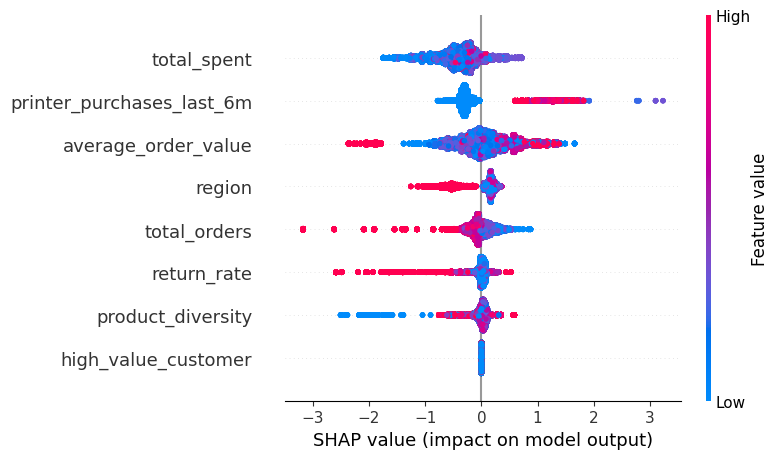

In [36]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load the trained XGBoost model
model_path = "xgboost_model.pkl"
multi_target_model = joblib.load(model_path)

# ✅ Load customer data
customers = pd.read_json("customers_info.json")  # Change to CSV if needed

# ✅ Select features (drop unnecessary columns)
X = customers.drop(['Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region'], axis=1, errors='ignore')
# Drop "Customer ID" and any other non-numeric columns
X = X.select_dtypes(include=['number'])
print("X Shape:", X.shape)
print("Columns in X:", X.columns)
print("Data Types:\n", X.dtypes)
print("Missing Values:\n", X.isnull().sum())

X = merged_df.select_dtypes(include=['number']).copy()  # Select only numeric columns


# Print expected features from the model
expected_features = multi_target_model.get_booster().feature_names
print("Expected Features:", expected_features)

# Print current features in X
print("Current Features in X:", X.columns.tolist())

# Ensure the columns match
X = X[expected_features]  # Reorder columns to match training data


# ✅ Create SHAP Explainer for XGBoost
explainer = shap.Explainer(multi_target_model)
shap_values = explainer(X)

# ✅ Global Feature Importance
shap.summary_plot(shap_values, X)



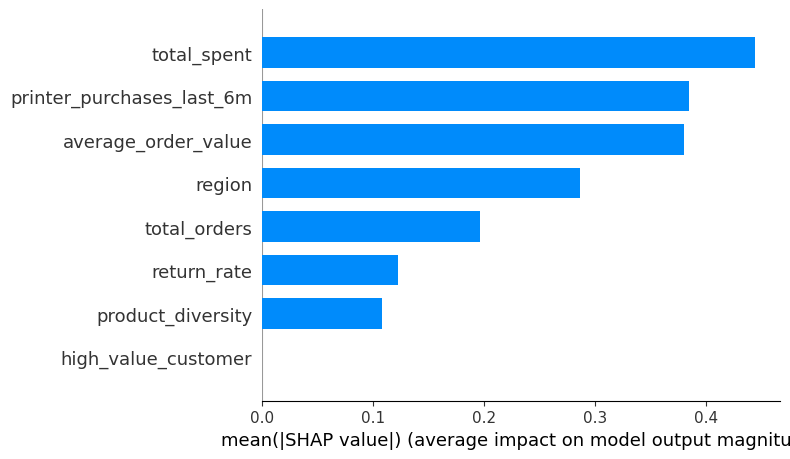

In [35]:
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X, plot_type="bar")


##**Using Scikit-Learn Pipelines for Streamlined Data Transformation**

In [37]:
import pandas as pd
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [38]:
# Define numerical and categorical features
numerical_features = ["total_spent", "average_order_value", "total_orders", "return_rate", "product_diversity"]
categorical_features = ["Region"]  # Ensure column name matches exactly

# Pipeline for numerical features (handling missing values + scaling)
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical features (handling missing values + encoding)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])


In [39]:
# Define numerical and categorical columns
numerical_features = ["total_spent", "average_order_value", "total_orders", "return_rate", "product_diversity"]
categorical_features = ["region"]

# Create transformers for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Fill missing values with median
    ("scaler", StandardScaler())                    # Standardize features
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing values with most common value
    ("encoder", OneHotEncoder(handle_unknown="ignore"))   # One-hot encode categorical values
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])


In [ ]:
# Define the full pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])


In [ ]:
# Ensure correct feature names
numerical_features = ["total_spent", "average_order_value", 'return_rate', "total_orders" , "product_diversity"]
categorical_features = ["region"]
# Convert column names to lowercase (if needed)
merged_df.columns = merged_df.columns.str.lower()

# Select features and target
X = merged_df[numerical_features + categorical_features]
Y = merged_df["printer_purchase"]

print("✅ X shape:", X.shape)
print("✅ Y shape:", Y.shape)


✅ X shape: (74370, 7)
✅ Y shape: (74370,)


In [ ]:
# Define X (features) and Y (target variable)
X = merged_df[numerical_features + categorical_features]  # Select relevant columns
Y = merged_df['printer_purchase']  # Replace with the actual target column name

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Train the pipeline
model_pipeline.fit(X_train, Y_train)

# Predict on test data
Y_pred = model_pipeline.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(Y_test, Y_pred)
print(f"✅ Model Accuracy: {accuracy:.2f}")


✅ Model Accuracy: 0.97


In [ ]:
# Save pipeline
joblib.dump(model_pipeline, "purchase_prediction_pipeline.pkl")

# Download the file in Google Colab
from google.colab import files
files.download("purchase_prediction_pipeline.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>